# Neural Network from scratch

大学院の課題より
要修正

# Libraries

In [1]:
#defaul libraries
#https://docs.python.org/ja/
import os

import math
import random
import pprint
import datetime

import gc
from pprint import pprint

import copy

import numpy as np #https://numpy.org/
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

import seaborn as sns
sns.set()

import plotly.graph_objects as go

from tqdm import tqdm #https://tqdm.github.io/


# Configuration

In [2]:
class CFG():

    debug=False
    seed=0

    point_num=1000

    epochs=150
    learning_rate=0.01
    kFold=5

def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

set_seed(CFG.seed)

# binary function

In [3]:
#3次元グラフの出力　https://plotly.com/python/3d-surface-plots/

class function_2_variable:
    """
    2入力1出力の関数
    """
    def __init__(self,f,x_range=(0,1),y_range=(0,1)):
        #二変数関数f(x,y)
        self.f=f
        #定義域
        self.x_range=x_range
        self.y_range=y_range

    def __call__(self,x:int,y:int):
        #定義域外は0を返す
        if not self.x_range[0]<=x<=self.x_range[1]:return 0
        if not self.y_range[0]<=y<=self.y_range[1]:return 0
        return self.f(x,y)

    def plot(self,x_range=None,y_range=None,d=100,lib='matplotlib',show=True):
        """
        二変数関数fを定義域の範囲(x_range,y_range)で可視化
        d:関数上の点を取る際の細かさ
        lib:可視化に使うライブラリ
        show:結果の出力
        """
        #定義域の設定
        if x_range==None:x_range=self.x_range
        if y_range==None:y_range=self.y_range

        if lib=='matplotlib':
            return self.plot_matplotlib(x_range,y_range,d,show)
        if lib=='plotly':
            return self.plot_plotly(x_range,y_range,d,show)

    def plot_plotly(self,x_range,y_range,d,show):
        """
        二変数関数fをplotlyで可視化
        d:関数上の点を取る際の細かさ
        lib:可視化に使うライブラリ
        show:結果の出力
        """

        #点の用意
        x=np.array(np.linspace(x_range[0],x_range[1],d))
        y=np.array(np.linspace(y_range[0],y_range[1],d))
        z=np.zeros([d,d])
        #関数上の点を取る
        for i in range(d):
            for j in range(d):
                z[i][j]=self.__call__(x[j],y[i])#???
        
        #plotly
        fig = go.Figure(data=[go.Surface(z=z,x=x,y=y)])

        fig.update_traces(
            #等高線
            contours_z=dict(
                show=True,
                usecolormap=True,
                highlightcolor="limegreen",
                project_z=True
            )
        )
        fig.update_layout(
            title='f(x,y)',
            autosize=False,
            scene_camera_eye=dict(x=-1.2, y=-1.2, z=1.5),
            width=500,
            height=500
        )

        if show:fig.show()
        plt.close()

        return x,y,z

    def plot_matplotlib(self,x_range,y_range,d,show):

        #点の用意 np meshgridに変換する？
        x=np.array(np.linspace(x_range[0],x_range[1],d))
        y=np.array(np.linspace(y_range[0],y_range[1],d))
        z=np.zeros([d,d])

        #matplotlib test

        # x=np.repeat([x],d,axis=0)
        # y=np.repeat([y],d,axis=0)
        _x,_y=np.meshgrid(x,y)

        for i in range(d):
            for j in range(d):
                z[i][j]=self.__call__(_x[i][j],_y[i][j])

        # print((x.shape))

        fig = plt.figure(figsize=(9, 9), facecolor="w")
        ax = fig.add_subplot(111, projection="3d")

        ax.plot_surface(_x,_y,z)
        ax.view_init(elev=30, azim=220)

        if show:plt.show()
        plt.close()

        return x,y,z


In [4]:
#math.sin(x)+math.cos(y)
#(1+math.sin(4*math.pi*x))*y/2
#x+y*4
# x*x*math.sin(2*math.pi*y)


#目的関数の定義
def f(x,y): return (math.sin(math.pi*x)-math.cos(math.pi*(y)))/2*y
target_f=function_2_variable(
    f,
    # x_range=(-math.pi,math.pi),
    # y_range=(-math.pi,math.pi),
    x_range=(-1,1),
    y_range=(-1,1),
)
#目的関数の可視化
x,y,z=target_f.plot(lib='plotly')

## points

In [5]:
#点群の用意

#0-1のランダム配列
points= np.random.rand(CFG.point_num,3)
#定義域に合わせて広げる
points[:,0]=(target_f.x_range[1]-target_f.x_range[0])*points[:,0]+target_f.x_range[0]
points[:,1]=(target_f.y_range[1]-target_f.y_range[0])*points[:,1]+target_f.y_range[0]
#対応するf(x,y)の値
points[:,2]=[target_f(point[0],point[1]) for point in points]

In [6]:
#点群の可視化
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0],
            y=points[:,1],
            z=points[:,2],
            mode='markers',
            marker=dict(
                size=1,
                color=points[:,2], # z軸で色を変える
                colorscale='Viridis',
                opacity=0.8
            )
        )
    ]
)
fig.update_layout(
    title='f(x,y)',
    autosize=False,
    scene_camera_eye=dict(x=-1.2, y=-1.2, z=1.5),#視点の初期値
    width=500,
    height=500
)
fig.show()

## animation

In [7]:
import matplotlib.animation as animation
from IPython.display import HTML

def graph_3D_animation(x,y,zs):
    """
    NNが学習していく様子をアニメーション化
    """
    fig = plt.figure(figsize=(9, 9), facecolor="w")
    ax = fig.add_subplot(111, projection="3d")
    _x,_y=np.meshgrid(x,y)

    if len(zs)>20:
        zs=[zs[int(i*(len(zs)/20))] for i in range(20)]

    def init():
        return

    def func(i):
        # x,y,z=f.plot(show=False)
        ax.clear()
        #ax.set_zlim(-1.5, 1.5)
        ax.set_zlim(-1, 1)
        
        ax.view_init(elev=30, azim=220)
        ax.plot_surface(_x,_y,zs[i])

        return

    ani = animation.FuncAnimation(fig, func,frames=len(zs), interval=150, init_func=init)
    plt.rc('animation', html='jshtml')
    plt.close()
    
    return HTML(ani.to_jshtml())

# Neural Network

## sigmoid

$$ \mathrm{sigmoid}(x) = \frac{1}{1+\mathrm{exp}(-x)} $$

$$ \frac{\partial \mathrm{sigmoid}(x)}{\partial x} \\
 =   \frac{\mathrm{exp}(-x)}{(1+\mathrm{exp}(-x))^2} \\
 = \frac{1}{1+\mathrm{exp}(-x)} \times \frac{\mathrm{exp}(-x)}{1+\mathrm{exp}(-x)} \\
 = \frac{1}{1+\mathrm{exp}(-x)} \times \left(1- \frac{1}{1+\mathrm{exp}(-x)}  \right) \\
 = \mathrm{sigmoid}(x) \times \left(1-\mathrm{sigmoid}(x) \right)
$$


In [8]:
class Sigmoid:
    """
    sigmoid関数
    """
    def __init__(self,gain=1.0):
        self.out=None #出力を保持

    # 順伝播 out=1/(1+exp(-x))
    def forward(self,x):
        self.out=1./(1. + np.exp(-x))
        return self.out

    #dout/dx=out*(1-out)
    def backward(self,d_loss_d_sigmoid_out):
        return d_loss_d_sigmoid_out * self.out*(1.-self.out)

    def __call__(self,x):
        return self.forward(x)

In [9]:
class ReLU:
    """
    ReLU関数
    """
    def __init__(self):
        self.out=None #出力を保持

    # out={x (x>=0), 0 (x<0)}
    def forward(self, x):
        self.out=x.copy()
        self.out[x < 0] = 0.0
        return self.out

    # dout/dx={1(out>=0), 0 out<0)}
    def backward(self,d_loss_d_relu_out):
        #d_loss_d_relu_in = ??
        return d_loss_d_relu_out * [int(x>0) for x in self.out]

    def __call__(self,x):
        return self.forward(x)

In [10]:
class Identity_Function:
    """
    恒等関数
    """
    def forward(self, x):
        return x

    def backward(self,d_loss_d_out):
        return d_loss_d_out

    def __call__(self,x):
        return self.forward(x)

In [11]:
class Linear():
    """
    線形層
    """
    def __init__(self,in_size,out_size):
        #入力サイズ
        self.in_size=in_size
        #出力サイズ
        self.out_size=out_size

        #層への入力，出力，勾配を保持
        self.in_=None
        self.out_=None
        self.grad=None

        #層の重み [out_size ,in_size+bias]
        self.weight=np.random.uniform(
            #重みを-1/√d〜1/√dの範囲の一様分布で初期化
            -1/math.sqrt(self.in_size),
            1/math.sqrt(self.in_size),
            (self.out_size, self.in_size+1)
        )
    
    def forward(self,x):
        self.in_=np.insert(x,0,1.,axis=0) # xの{axis}軸の0番目にbias用の入力1を入れる
        self.out_=self.weight @ self.in_
        return self.out_

    def __call__(self,x):
        return self.forward(x)

    def backward(self,d_loss_d_weightout):
        """
        d_loss_d_weightout:損失関数に対する出力の微分 [out_size]
        """
        # 重みの勾配を計算
        #[out_size ,in_size+bias] = [out_size,1] @ [1,in_size+bias]
        self.grad=d_loss_d_weightout[:,np.newaxis] @ self.in_[np.newaxis,:]

        # 損失関数に対する入力の微分を返す
        #[1,in_size] = [1,out_size] @ [out_size,in_size] weightのbias部分を取り除く
        d_loss_d_in_=d_loss_d_weightout[np.newaxis,:] @ self.weight[:,1:]

        return np.squeeze(d_loss_d_in_)
        

    #重みを勾配(self.grad)で更新
    def update(self,learning_rate):
        self.weight-=learning_rate*self.grad


In [12]:
class LossFunction:
    """損失関数"""
    # 1/2 \Sigma(target-x)^2
    def loss(self,x,target):
        diff=target-x
        return (diff@diff)/2.

    def backward(self,x,target):
        return -(target-x)#??

    def __call__(self,x,target):
        return self.loss(x,target)

loss_fun=LossFunction()

In [13]:
class NeuralNetwork:
    """
    ニューラルネットワーク
    """
    def __init__(self,sequential):
        # 層を並べる
        self.sequential=sequential

    def forward(self,x):
        # 順伝播
        for module in self.sequential:
            x=module(x)
        return x

    def fit(self,x,target,loss_fun,update=True):
        # 順伝播
        prediction=self.forward(x)
        # Loss関数に対する出力の微分
        grad=loss_fun.backward(prediction,target)

        # 誤差逆伝播
        for module in reversed(self.sequential):
            grad=module.backward(grad)

        # 線形層の重みを更新
        for module in reversed(self.sequential):
            if (not update) or (type(module)!=Linear):continue
            module.update(CFG.learning_rate)

        return loss_fun(prediction,target)

    def __call__(self,x):
        return self.forward(x)


In [14]:
#関数の定義
# def nn_f(x1,x2): return neural_network(np.array([x1,x2]))
# neural_network_f=function_2_variable(
#     nn_f,
#     x_range=target_f.x_range,
#     y_range=target_f.y_range
# )
# _,_,_=neural_network_f.plot(lib='plotly')

# training

In [15]:
def train(model,data):
    """
    モデルの学習
    """
    losses={
        'train':[],
        'val':[]
    }
    zs={
        'train':[],
        'val':[]
    }

    for epoch in tqdm(range(CFG.epochs)):

        for phase in ['train','val']:
            loss=[]
            for x,z in zip(data[phase][0],data[phase][1]):
                l=model.fit(
                    x,np.array([z]),
                    loss_fun=loss_fun,
                    update=(phase=='train')
                )
                loss.append(l)
            
            losses[phase].append(np.mean(loss))

        # x,y,z=neural_network_f.plot(show=False)
        # zs.append(z)

    return losses,zs


## cross validation

In [16]:

def cross_validation(sequential):
    # cross validation


    kf = KFold(n_splits=CFG.kFold)

    data={
        'train':None,
        'val':None,
    }
    all_losses=[]

    for train_index, val_index in kf.split(points):

        # modelの宣言
        neural_network=NeuralNetwork(copy.deepcopy(sequential))

        data['train'] = points[train_index,0:2], points[train_index,2]
        data['val']   = points[val_index,0:2],points[val_index,2]

        losses,zs=train(neural_network,data)
        # plt.plot(losses['train'])
        # plt.plot(losses['val'])
        # plt.show()

        all_losses.append(losses)

    def nn_f(x1,x2): return neural_network(np.array([x1,x2]))
    neural_network_f=function_2_variable(
        nn_f,
        x_range=target_f.x_range,
        y_range=target_f.y_range
    )
    _,_,_=neural_network_f.plot(lib='plotly')


    return all_losses


In [17]:
unit_models=[
    [
        Linear(2,4),
        ReLU(),
        Linear(4,1),
        Identity_Function(),
    ],
    [
        Linear(2,16),
        ReLU(),
        Linear(16,1),
        Identity_Function(),
    ],
    [
        Linear(2,64),
        ReLU(),
        Linear(64,1),
        Identity_Function(),
    ],
]

layer_models=[
    [
        Linear(2,4),
        ReLU(),
        Linear(4,1),
        Identity_Function(),
    ],
    [
        Linear(2,4),
        ReLU(),
        Linear(4,4),
        ReLU(),
        Linear(4,1),
        Identity_Function(),
    ],
    [
        Linear(2,4),
        ReLU(),
        Linear(4,4),
        ReLU(),
        Linear(4,4),
        ReLU(),
        Linear(4,1),
        Identity_Function(),
    ],
]

activation_models=[
    [
        Linear(2,64),
        Sigmoid(),
        Linear(64,1),
        Identity_Function(),
    ],
    [
        Linear(2,64),
        ReLU(),
        Linear(64,1),
        Identity_Function(),
    ],
]


['Linear', 'ReLU', 'Linear', 'Identity_Function']


100%|██████████| 150/150 [00:17<00:00,  8.60it/s]


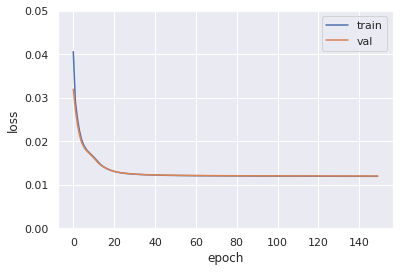

['Linear', 'ReLU', 'Linear', 'Identity_Function']


100%|██████████| 150/150 [00:18<00:00,  8.14it/s]


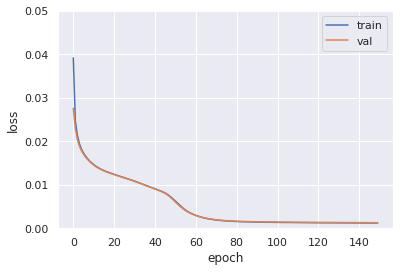

['Linear', 'ReLU', 'Linear', 'Identity_Function']


100%|██████████| 150/150 [00:28<00:00,  5.26it/s]


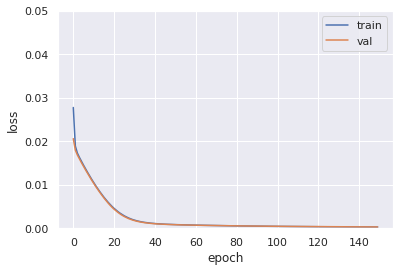

In [18]:
for models in [unit_models]:#[unit_models,layer_models,activation_models]:
    for model in models:
        pprint([module.__class__.__name__ for module in model])
        all_losses=cross_validation(model)
        # 損失グラフの平均を出力
        tr=[
            np.mean(x) for x in zip(
                all_losses[0]['train'],
                all_losses[1]['train'],
                all_losses[2]['train'],
                all_losses[3]['train'],
                all_losses[4]['train'],
            )
        ]
        va=[
            np.mean(x) for x in zip(
                all_losses[0]['val'],
                all_losses[1]['val'],
                all_losses[2]['val'],
                all_losses[3]['val'],
                all_losses[4]['val'],
            )
        ]
        plt.plot(tr)
        plt.plot(va)
        plt.legend(['train','val'])
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.ylim(0,0.05)
        plt.show()

## visualization

100%|██████████| 150/150 [02:23<00:00,  1.04it/s]


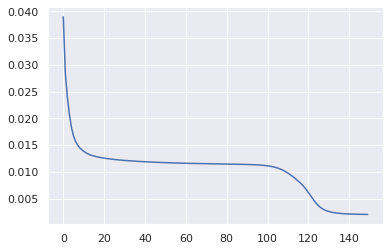

In [19]:
neural_network=NeuralNetwork(
    [
        Linear(2,8),
        ReLU(),
        Linear(8,1),
        Identity_Function(),
    ],
)

def nn_f(x1,x2): return neural_network(np.array([x1,x2]))
neural_network_f=function_2_variable(
    nn_f,
    x_range=target_f.x_range,
    y_range=target_f.y_range
)

zs=[]
x,y,z=neural_network_f.plot(show=False)
zs.append(z)

tmp=[]
for epoch in tqdm(range(CFG.epochs)):

    # CFG.learning_rate=CFG.learning_rate*(0.9**epoch)
    loss=[]
    for a,b,c in points:
        # print(a,b,c)
        loss__=neural_network.fit(np.array([a,b]),np.array([c]),loss_fun=loss_fun)
        loss.append(loss__)
    tmp.append(np.mean(loss))
    #tmp.extend(loss)

    x,y,z=neural_network_f.plot(show=False)
    zs.append(z)

plt.plot(tmp)


In [20]:
_,_,_=neural_network_f.plot(lib='plotly')

In [21]:
graph_3D_animation(x,y,zs)